# Overview of the Golden Bullet
## Mission
To predict the movement of stocks with an above 80% success rate. 
I will first start with long term, unidimentional, "stable" stocks – e.g. blue chips – and then evolve to more ad hoc, multidimentional, "volital" stocks – e.g. penny stocks, ETFs, futures, etc.

Much of this work will be utilizing concepts from Boris https://github.com/borisbanushev/stockpredictionai/blob/f1984b952b86d61653758ddcd0dc6dd3735a5e5b/TradingAI.ipynb

## Workflow
    Initial Phase
    1. Get simple data – prices, high-lows, etc. on the Goldmann Sachs (NYSE:GS) common stock
    
    2. Clean data and prepare it for predictions
    
    3. Use CatBoost to predict the stock prices of a previous year (1.e. 2021)
    
    4. Evaluate: cross-validate, feature importance, param tuning, etc.
    
   
    Intermediate Phase
    5. Rerun the pipeline but with more features delineated by Boris - includes catagorical features
    
    6. Evaluate and adjust
    
    7. Rerun with statistical/mathmatical metrics – GAN, Bayesian, etc.
    
    8. Evaluate and Adjust
    
    9. Repeat until real-world ready
    
    
    Advanced Phase 
    1. Test in real-world - start by observing, making note of the timeframes which are accurate, what skews the model, what deviance there is, etc. – "Would I put money on this?"
    
    2. Get the simple model to workability, then move onto the more complex model
    
    3. Enjoy!

# Data Processing

In [47]:
# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx


print("Setup Complete")

ModuleNotFoundError: No module named 'bert'

In [5]:
pwd

'/Users/aidanlew'

In [6]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [7]:

def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [8]:
basic_golden_df = pd.read_excel('../Documents/stock_data_trial.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'],
                    engine = 'openpyxl',
                    #date_parser=parser
                         )

basic_golden_df.set_index(['Date'])
basic_golden_df.dropna(axis=0, inplace=True) 

#basic_golden_df.columns
basic_golden_df.head(10)

,Date,Open,High,Low,Close,Volume
0,2019-01-02 16:00:00,164.33,172.25,163.35,172.03,3999444
1,2019-01-03 16:00:00,170.66,171.77,168.29,169.51,4060393
2,2019-01-04 16:00:00,172.99,176.00,171.10,175.05,3788312
3,2019-01-07 16:00:00,175.23,177.83,172.27,176.02,3152092
4,2019-01-08 16:00:00,177.78,178.10,172.90,175.37,2692684
5,2019-01-09 16:00:00,176.10,177.69,174.91,176.47,3321697
6,2019-01-10 16:00:00,175.66,178.07,175.50,176.00,2808732
7,2019-01-11 16:00:00,175.10,177.04,172.42,176.93,3183036
8,2019-01-14 16:00:00,174.52,179.54,174.10,178.72,3361688
9,2019-01-15 16:00:00,178.32,179.99,176.40,179.91,2911802


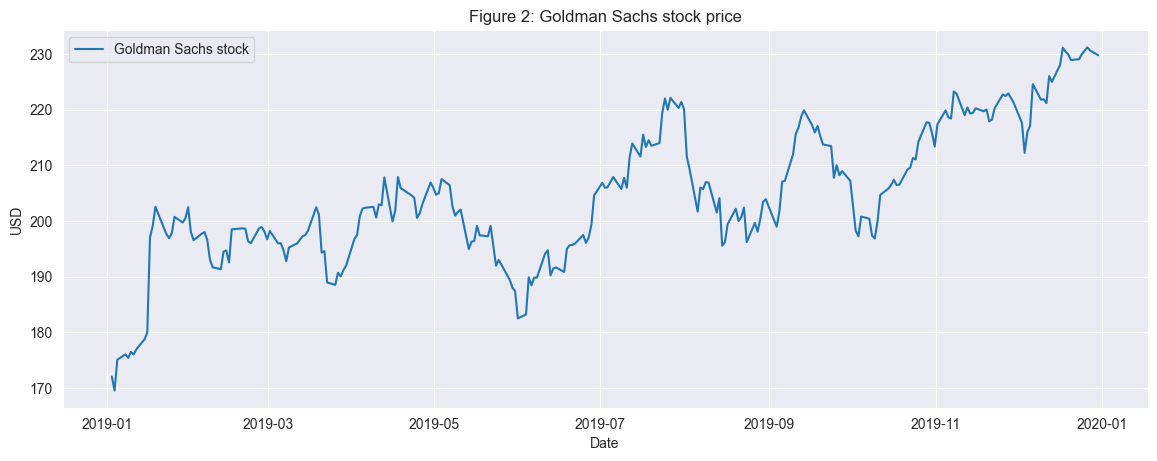

In [9]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(basic_golden_df['Date'], basic_golden_df['Close'], label='Goldman Sachs stock')
#plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()


In [10]:
num_training_days = int(basic_golden_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    basic_golden_df.shape[0]-num_training_days))

Number of training days: 175. Number of test days: 76.


## Techincal Indicators

In [29]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(7).mean()
    dataset['ma21'] = dataset['Close'].rolling(21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [37]:
basic_TI_df = get_technical_indicators(basic_golden_df)
basic_TI_df.tail()

,Date,Open,High,Low,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
246,2019-12-23 16:00:00,229.66,230.48,228.41,229.09,1671705,228.942857,223.375238,223.394722,226.662372,3.267651,5.210045,233.795328,212.955148,229.159225,228.09
247,2019-12-24 13:00:00,228.98,229.95,228.37,229.91,467722,229.644286,223.833810,223.877335,227.162007,3.284673,5.396293,234.626395,213.041224,229.659742,228.91
248,2019-12-26 16:00:00,230.26,232.20,229.99,231.21,1704161,230.097143,224.236667,224.420495,227.784776,3.364280,5.624133,235.484932,212.988401,230.693247,230.21
249,2019-12-27 16:00:00,231.81,232.21,230.47,230.66,1343887,230.027143,224.627619,224.882681,228.227118,3.344437,5.786738,236.201096,213.054143,230.671082,229.66
250,2019-12-30 16:00:00,231.68,231.68,229.50,229.80,1494667,229.934286,224.953810,225.246927,228.469100,3.222173,5.836651,236.627112,213.280507,230.090361,228.80


In [45]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

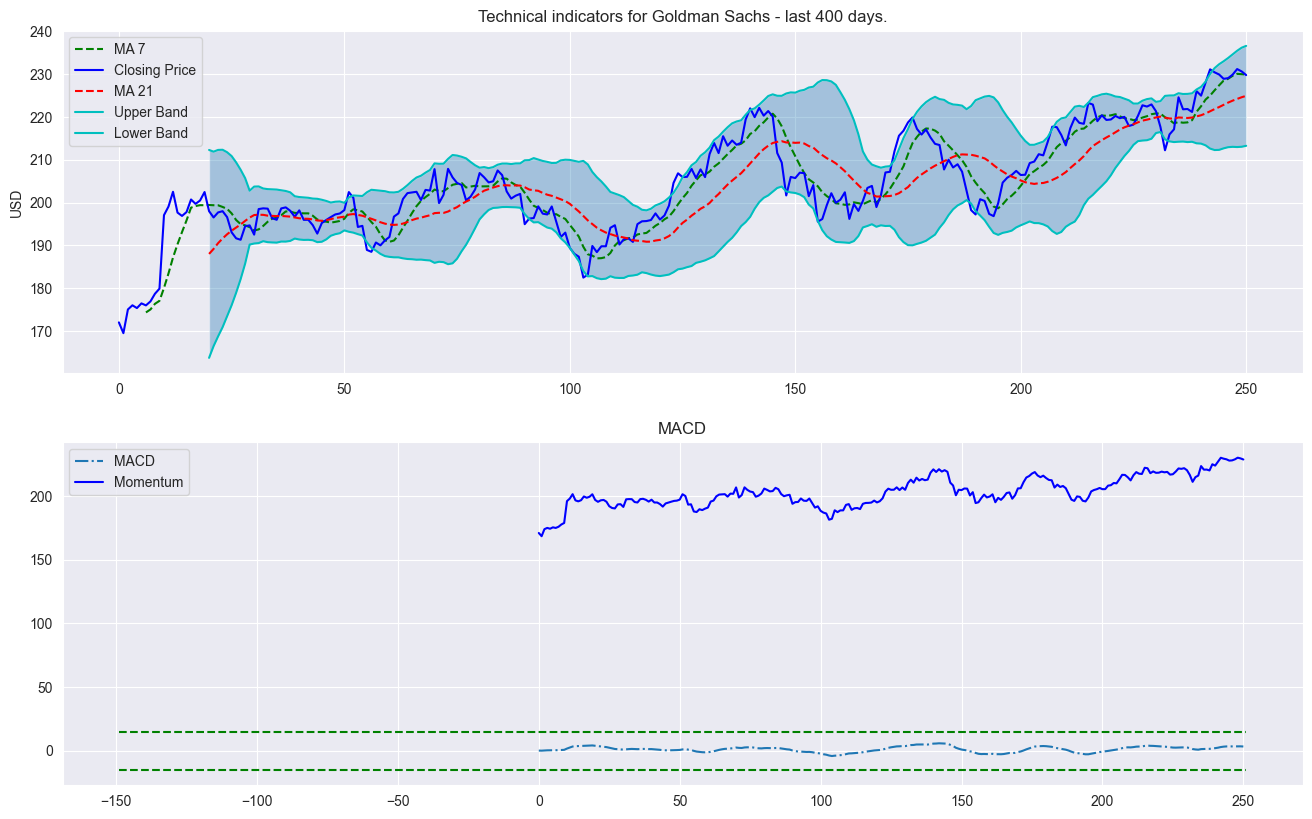

In [46]:
plot_technical_indicators(basic_TI_df, 400)

## Sentiment Analysis 
https://www.youtube.com/watch?v=szczpgOEdXs

# Fourier Transforms